In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install arch
#!pip install pmdarima 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.1/925.1 kB 4.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import random
import itertools
from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
#import pmdarima as pm
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from matplotlib import pyplot as plt

In [3]:
#df_credit=pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df_credit=pd.read_csv("creditcardoriginal.csv")

In [4]:
df_credit.count()
#print(df_credit[df_credit['Class'] == 1]['Time'])
df_credit[df_credit['Class'] == 1].count()
df_credit[df_credit['Class'] == 1]['Time'].nunique()

468

In [5]:
df_credit.head(10)
# Group by Time and count fraudulent entries (Class == 1)
fraud_counts = df_credit[df_credit['Class'] == 1].groupby('Time').size()

# Filter for times with multiple fraudulent entries
multiple_frauds = fraud_counts[fraud_counts > 1]

# Display the times with multiple fraudulent entries
print(multiple_frauds)

# Optional: Display the full rows for those times
if not multiple_frauds.empty:
    times_with_multiple_frauds = multiple_frauds.index
    multiple_fraud_entries = df_credit[df_credit['Time'].isin(times_with_multiple_frauds)]
    print(multiple_fraud_entries)


Time
68207.0     6
84204.0     4
85285.0     4
93853.0     4
93860.0     4
93879.0     4
94362.0     4
148053.0    2
dtype: int64
            Time         V1         V2         V3         V4         V5  \
102440   68207.0  -1.171197   1.039103   1.405342   0.972502   0.220715   
102441   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
102442   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
102443   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
102444   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
102445   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
102446   68207.0 -13.192671  12.785971  -9.906650   3.320337  -4.801176   
141257   84204.0  -0.937843   3.462889  -6.445104   4.932199  -2.233983   
141258   84204.0  -0.937843   3.462889  -6.445104   4.932199  -2.233983   
141259   84204.0  -1.927453   1.827621  -7.019495   5.348303  -2.739188   
141260   84204.0  -1.927453   1.827621  -7.01

In [5]:
# # Check for NaN values
# nan_values = df_credit['Amount'].isna()
# print(f"NaN values in 'Amount':\n{nan_values.sum()}")  # Count of NaN values

# # Check for Infinite values
# inf_values = np.isinf(df_credit['Amount'])
# print(f"Infinite values in 'Amount':\n{inf_values.sum()}")  # Count of infinite values

In [6]:
# # arima interpolate
# # if there is no fraud transaction at a single 'time', keep the mean amount; otherwise keep the max amount of fraud at that 'time'
# def process_transactions(group):
#     if group['Class'].sum() == 0:
#         # If no fraud, keep the mean of the Amount
#         return group.assign(Amount=group['Amount'].mean()).iloc[0:1] 
#     else:
#         # If fraud exists, keep the transaction with the max fraud amount
#         fraud_transaction = group[group['Class'] == 1].nlargest(1, 'Amount')
        
#         # Ensure the Amount column for the fraud transaction is updated correctly
#         group.loc[fraud_transaction.index, 'Amount'] = fraud_transaction['Amount'].values
        
#         # Return the group with only the fraud transaction and the updated Amount
#         return group.loc[fraud_transaction.index]

# # Apply the function to each group by 'time'
# df_processed = df_credit.groupby('Time').apply(process_transactions).reset_index(drop=True)

# # Show the modified dataframe
# print(df_processed)

In [7]:
# aggregate data in each time
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_credit is already loaded as a DataFrame

# Grouping by 'Time' and processing
def process_group(group):
    if group['Class'].sum() > 0:  # If any fraud exists in the group
        return group[group['Class'] == 1].iloc[0]  # Take the first fraud entry
    else:
        return group.mean(numeric_only=True)  # Take the average for non-fraud cases

df_processed = df_credit.groupby('Time').apply(process_group).reset_index(drop=True)


In [8]:

# df_processed.to_csv('creditcard_processed.csv', index=False)

# print("File saved as 'creditcard_processed.csv'")

# read the processed data
df_processed=pd.read_csv("creditcard_processed.csv")

/var/folders/7z/kw5cl_f90q97m2h5x3s2bktc0000gn/T/ipykernel_69451/2091963438.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fraud_points = df_full_time[st:st+1000][df_full_time['Class'] == 1]


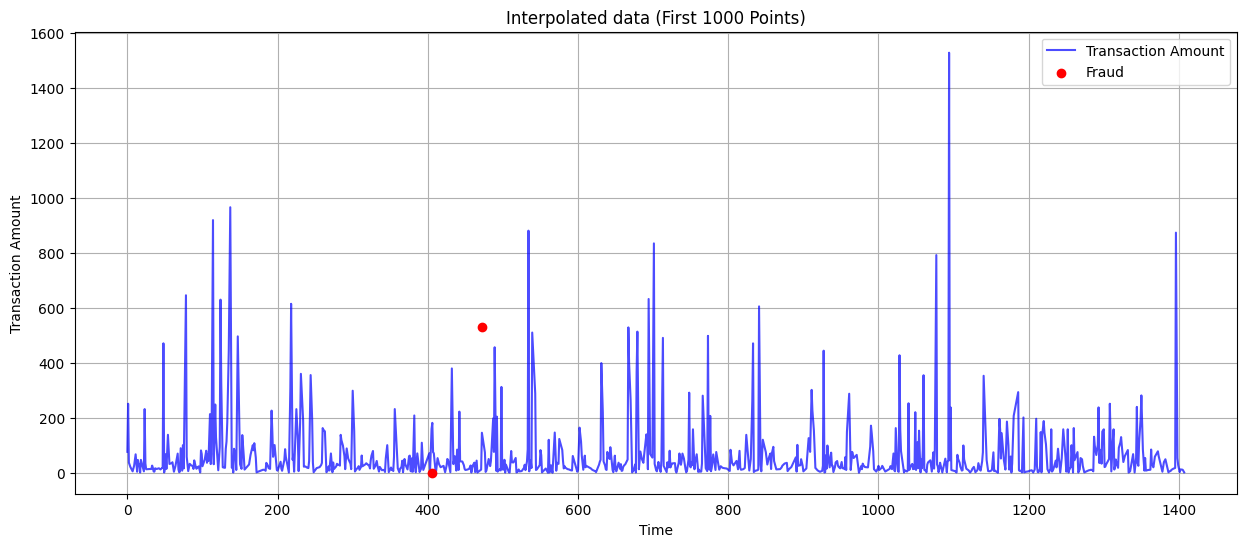

In [11]:
# Plotting the interpolated first 1000 time points
plt.figure(figsize=(15, 6))
st=0
plt.plot(df_processed['Time'][st:st+1000], df_full_time['Amount'][st:st+1000],color='blue', label='Transaction Amount',linewidth=1.5,alpha=0.7)

# Highlight fraud entries for the first 100 points
fraud_points = df_full_time[st:st+1000][df_full_time['Class'] == 1]
plt.scatter(fraud_points['Time'], fraud_points['Amount'], color='red', label='Fraud', zorder=5)

plt.xlabel('Time')
plt.ylabel('Transaction Amount')
plt.title('Interpolated data (First 1000 Points)')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# interpolate to get regular time interval

# Create a full range of time points
full_time_range = np.arange(df_processed['Time'].min(), df_processed['Time'].max() + 1)

# Reindex with full time range, inserting NaN for missing values
df_full_time = df_processed.set_index('Time').reindex(full_time_range).reset_index()
df_full_time.rename(columns={'index': 'Time'}, inplace=True)

# Fill missing entries linearly for numeric columns and set Class to 0
numeric_columns = df_processed.columns.drop(['Class'])
df_full_time[numeric_columns] = df_full_time[numeric_columns].interpolate(method='linear')
df_full_time['Class'] = df_full_time['Class'].fillna(0).astype(int)


In [13]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Non-stationary")
    else:
        print("Stationary")

# Stationarity check
check_stationarity(df_full_time['Amount'])
# Stationarity check of the first difference of time series
check_stationarity(df_full_time['Amount'].diff().dropna())

ADF Statistic: -40.877758028070396
p-value: 0.0
Stationary
ADF Statistic: -79.32651598584964
p-value: 0.0
Stationary


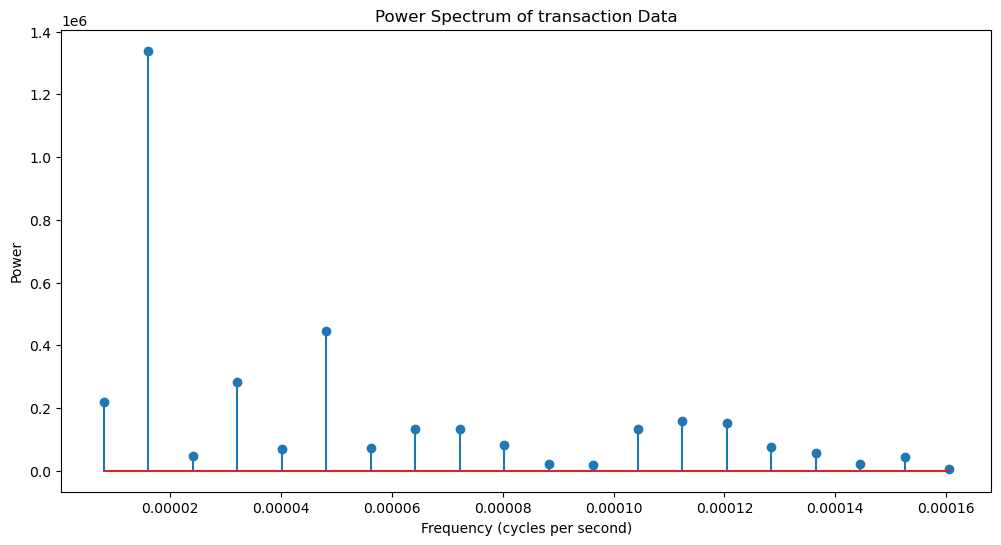

In [ ]:
# check periodicity of the data using FFT
import numpy as np
import matplotlib.pyplot as plt
df = df_processed
# Extract the values from df
y = df['Amount'].values
N = len(y)

# Compute the FFT
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(N, d=1)  # d=1 if daily data

# Take only the positive frequencies since the FFT is symmetrical for real data
mask = freqs > 0
freqs = freqs[mask]
power = np.abs(Y[mask])

# Plot the power spectrum
plt.figure(figsize=(12,6))
plt.stem(freqs[:20], power[:20])
plt.title('Power Spectrum of transaction Data')
plt.xlabel('Frequency (cycles per second)')
plt.ylabel('Power')
plt.show()


<h1>Data processing </h1>

In [28]:
# masking the data

# 1) Make a copy of the original data

df_original = df_full_time.copy()
df = df_full_time.copy()

# 2) Detect anomalies using SESD on original data, not needed if labels are present
#anomaly_indices = sesd.seasonal_esd(df_original['Amount'], periodicity=10, hybrid=True, max_anomalies=50, alpha=3)
anomaly_indices = df_original[df_original['Class'] == 1].index
#print(len(anomaly_indices))
print(len(anomaly_indices))
# Record the outlier values from the original data
outlier_values = df_original.iloc[anomaly_indices]['Amount'].copy()

# 3) Interpolate these outliers in a working copy (df)
df.iloc[anomaly_indices, df.columns.get_loc('Amount')] = np.nan
df['Amount'] = df['Amount'].interpolate(method='linear')

# 4) Randomly select equal amount of normal indices (not anomalies)
all_indices = np.arange(len(df))
normal_candidates = np.setdiff1d(all_indices, anomaly_indices)
random_indices = np.random.choice(normal_candidates, size=len(anomaly_indices), replace=False)

# Record the original values at these random indices from df_original
random_values = df_original.iloc[random_indices]['Amount'].copy()

# Set these random entries to NaN and interpolate in df
df.iloc[random_indices, df.columns.get_loc('Amount')] = np.nan
df['Amount'] = df['Amount'].interpolate(method='linear')

df['Amount_diff'] = df['Amount'].diff().dropna()







468


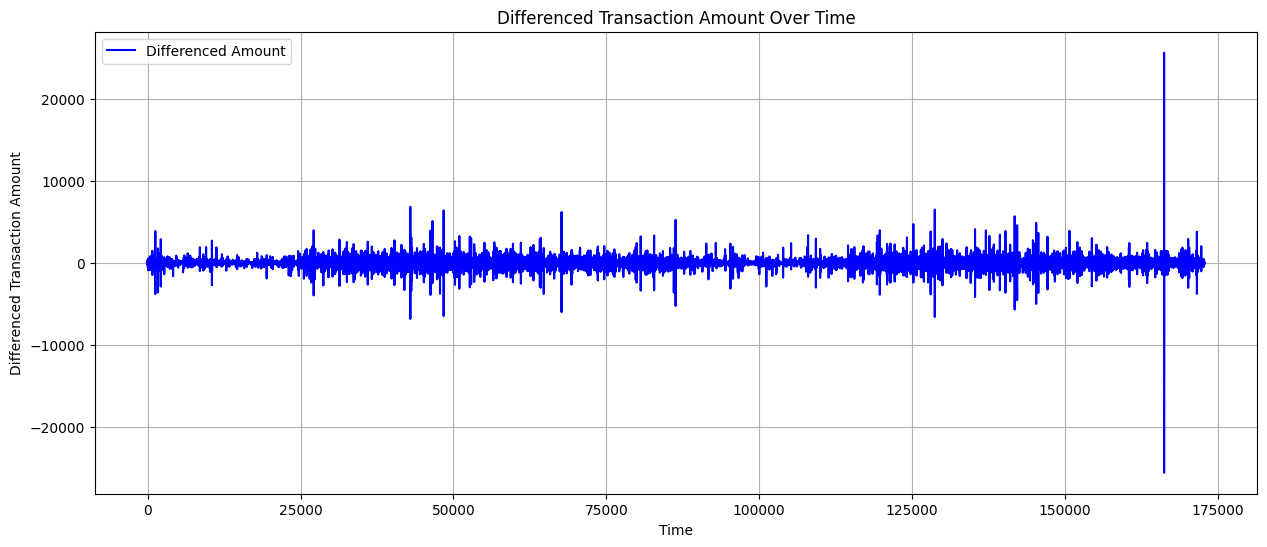

In [30]:
import matplotlib.pyplot as plt

# Plot the differenced data
plt.figure(figsize=(15, 6))
plt.plot(df['Time'], df['Amount_diff'], label='Differenced Amount', color='blue', linewidth=1.5)
plt.title("Differenced Transaction Amount Over Time")
plt.xlabel("Time")
plt.ylabel("Differenced Transaction Amount")
plt.legend()
plt.grid(True)
plt.show()

<h1>Vectorized approaches</h1>

Note we DIFFERENCE the amount 

<h3>ARIMA</h3>

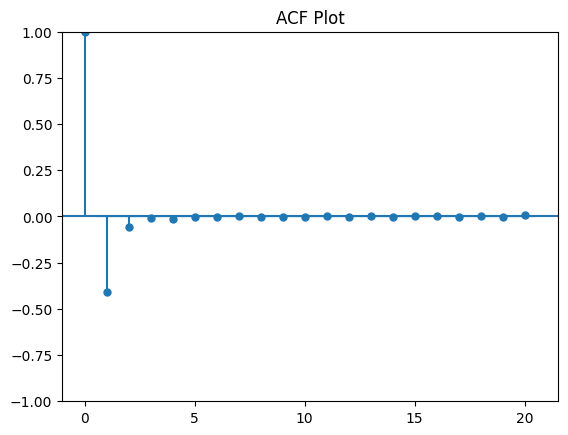

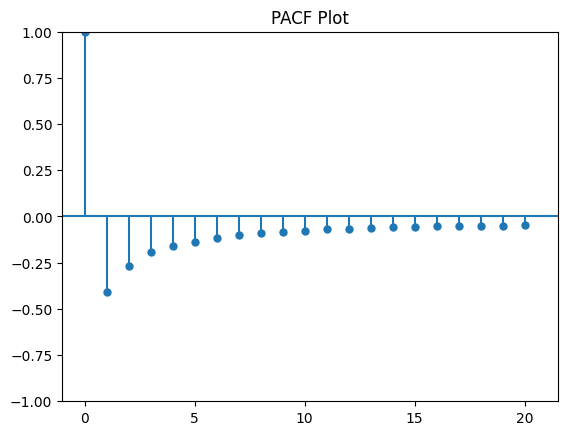

In [31]:
# Plot ACF and PACF to refine p and q
plot_acf(df['Amount_diff'].dropna(), lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(df['Amount_diff'].dropna(), lags=20)
plt.title("PACF Plot")
plt.show()


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# 5) Fit the ARIMA model on the modified data
model = ARIMA(df['Amount_diff'], order=(2,0,1)).fit()

# Compute fitted values for plotting
fitted_values = model.fittedvalues

# 6) Compute residuals against original values (not required for plotting, 
#    but shown here as an example)
fitted_outliers = fitted_values.loc[df.index[anomaly_indices]]
residuals_outliers = np.abs(outlier_values.values - fitted_outliers.values)

fitted_random = fitted_values.loc[df.index[random_indices]]
residuals_random = np.abs(random_values.values - fitted_random.values)

print("Residuals for outlier indices:")
print(pd.Series(residuals_outliers).describe())
print("\nResiduals for randomly interpolated normal indices:")
print(pd.Series(residuals_random).describe())


Residuals for outlier indices:
count     468.000000
mean      172.528055
std       344.198169
min         0.087273
25%        34.018294
50%        53.998984
75%       142.286646
max      3556.916391
dtype: float64

Residuals for randomly interpolated normal indices:
count     468.000000
mean      132.535025
std       271.546482
min         0.352091
25%        23.620093
50%        45.267649
75%       123.642225
max      3782.832023
dtype: float64


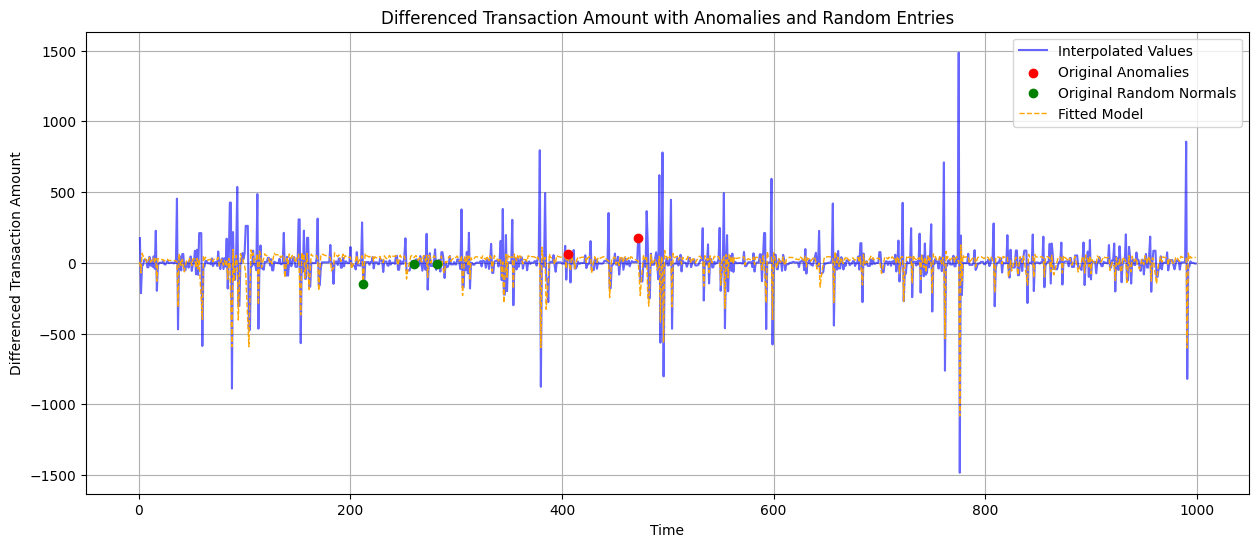

In [58]:
# 7) Plot the final results
plt.figure(figsize=(15, 6))

# Final interpolated series (differenced)
plt.plot(df['Time'][:1000], df['Amount_diff'][:1000], color="blue", label='Interpolated Values', linewidth=1.5,alpha=0.6)

# Filter anomalies and random entries within the first 1000 seconds
anomalies_in_range = anomaly_indices[anomaly_indices < 1000]
random_in_range = random_indices[random_indices < 1000]

# Plot the original anomaly points (red)
plt.scatter(df['Time'].iloc[anomalies_in_range], df['Amount_diff'].iloc[anomalies_in_range],
            color='red', label='Original Anomalies', zorder=5)

# Plot the original randomly masked points (green)
plt.scatter(df['Time'].iloc[random_in_range], df['Amount_diff'].iloc[random_in_range],
            color='green', label='Original Random Normals', zorder=5)

# Fitted model values (orange dashed line)
plt.plot(df['Time'][:1000], fitted_values[:1000], color='orange', linestyle='--', label='Fitted Model', linewidth=1)

# Titles, labels, and legend
plt.title("Differenced Transaction Amount with Anomalies and Random Entries")
plt.xlabel('Time')
plt.ylabel('Differenced Transaction Amount')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
# 8) Evaluation
# # detection performance using empirical 
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

# Suppose residuals_outliers and residuals_random are already defined as per your previous steps.
# residuals_outliers: absolute residuals for the 30 known anomaly points
# residuals_random: absolute residuals for the 30 known normal points

alpha = 0.05  # For a 95% quantile, alpha = 0.05
threshold = np.quantile(residuals_random, 1 - alpha)

print(f"Selected threshold at the 95% quantile of normal residuals: {threshold}")

# Create a single array of predictions and true labels for the 60 points
# True labels: outliers = 1, normal = 0
true_labels = np.array([1]*len(residuals_outliers) + [0]*len(residuals_random))

# Combine residual arrays
all_residuals = np.concatenate([residuals_outliers, residuals_random])

# Predict anomaly if residual > threshold
predictions = (all_residuals > threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# You can also compute precision, recall, F1 score
precision = tp / (tp + fp) if (tp+fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision+recall) > 0 else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Selected threshold at the 95% quantile of normal residuals: 498.7137850550038
Confusion Matrix:
[[444  24]
 [426  42]]
TN: 444, FP: 24, FN: 426, TP: 42
Precision: 0.636, Recall: 0.090, F1: 0.157


<h3> VAR</h3> for differenced data

In [61]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for VAR using the differenced Amount and the original PCA components
columns_for_var = ['Amount_diff', 'V1', 'V2', 'V3', 'V4', 'V5']
df_var = df[columns_for_var].dropna()  # Drop rows with NaN values
df_var.info()

# Fit a VAR model on the differenced data
var_model = VAR(df_var)
var_results = var_model.fit(maxlags=10)  # Choose lag order (e.g., 10)

# Compute fitted values (only for 'Amount_diff')
fitted_values_diff = var_results.fittedvalues['Amount_diff']

# Restore fitted values to the original scale for plotting and evaluation
fitted_values_original_scale = fitted_values_diff.cumsum() + df['Amount'].iloc[0]

# Compute residuals for outlier values
fitted_outliers = fitted_values_original_scale.loc[df.index[anomaly_indices]]
residuals_outliers = np.abs(outlier_values.values - fitted_outliers.values)

# Compute residuals for random masked normal entries
fitted_random = fitted_values_original_scale.loc[df.index[random_indices]]
residuals_random = np.abs(random_values.values - fitted_random.values)


<class 'pandas.core.frame.DataFrame'>
Index: 172792 entries, 1 to 172792
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Amount_diff  172792 non-null  float64
 1   V1           172792 non-null  float64
 2   V2           172792 non-null  float64
 3   V3           172792 non-null  float64
 4   V4           172792 non-null  float64
 5   V5           172792 non-null  float64
dtypes: float64(6)
memory usage: 9.2 MB


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


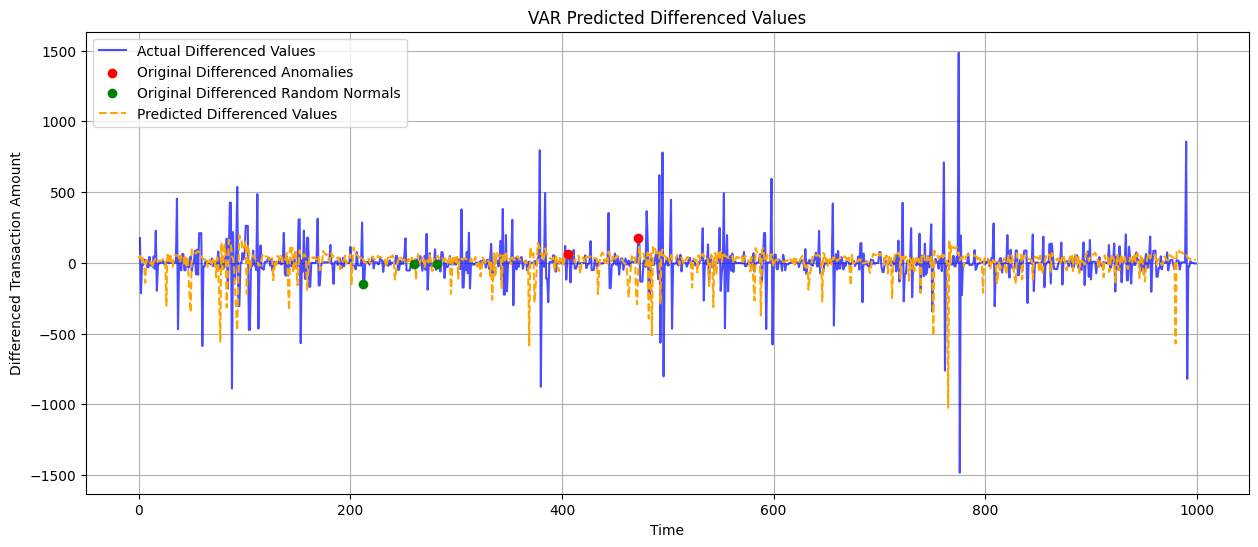

In [67]:
# Plot the final results for differenced values
plt.figure(figsize=(15, 6))

# Final interpolated differenced series
plt.plot(df['Time'][:1000], df['Amount_diff'][:1000], color="blue", label="Actual Differenced Values", linewidth=1.5, alpha=0.7)

# Filter anomalies and random entries within the first 1000 seconds
anomalies_in_range = anomaly_indices[anomaly_indices < 1000]
random_in_range = random_indices[random_indices < 1000]

# Plot the original anomaly points (red) for the differenced values
plt.scatter(df['Time'].iloc[anomalies_in_range], df['Amount_diff'].iloc[anomalies_in_range],
            color='red', label="Original Differenced Anomalies", zorder=5)

# Plot the original randomly masked points (green)
plt.scatter(df['Time'].iloc[random_in_range], df['Amount_diff'].iloc[random_in_range],
            color='green', label="Original Differenced Random Normals", zorder=5)

# Fitted model values (predicted differences)
plt.plot(df['Time'][:1000], fitted_values_diff[:1000], color="orange", linestyle="--", label="Predicted Differenced Values", linewidth=1.5)

plt.title("VAR Predicted Differenced Values")
plt.xlabel("Time")
plt.ylabel("Differenced Transaction Amount")
plt.legend()
plt.grid(True)
plt.show()


In [68]:
# Evaluation
alpha = 0.05  # For a 95% quantile
threshold = np.quantile(residuals_random, 1 - alpha)

print(f"Selected threshold at the 95% quantile of normal residuals: {threshold}")

# Create true labels: outliers = 1, normal = 0
true_labels = np.array([1] * len(residuals_outliers) + [0] * len(residuals_random))

# Combine residual arrays
all_residuals = np.concatenate([residuals_outliers, residuals_random])

# Predict anomaly if residual > threshold
predictions = (all_residuals > threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# Compute precision, recall, F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Selected threshold at the 95% quantile of normal residuals: 264978.9621363778
Confusion Matrix:
[[444  24]
 [443  25]]
TN: 444, FP: 24, FN: 443, TP: 25
Precision: 0.510, Recall: 0.053, F1: 0.097


<h3>VARMA (not done)</h3> 

In [49]:
from statsmodels.tsa.api import VARMAX

# Prepare the data for VARMA using the differenced Amount and PCA components
columns_for_varma = ['Amount_diff', 'V1', 'V2', 'V3', 'V4', 'V5']
df_varma = df[columns_for_varma].dropna()  # Drop rows with NaN values

# Fit a VARMA model on the differenced data
varma_model = VARMAX(df_varma, order=(2, 1)).fit(disp=False)

# Compute fitted values (only for 'Amount_diff')
fitted_values_diff = varma_model.fittedvalues['Amount_diff']

# Restore fitted values back to the original scale
fitted_values_original_scale = fitted_values_diff.cumsum() + df['Amount'].iloc[0]

# Compute residuals for outlier values
fitted_outliers = fitted_values_original_scale.loc[df.index[anomaly_indices]]
residuals_outliers = np.abs(outlier_values.values - fitted_outliers.values)

# Compute residuals for random masked normal entries
fitted_random = fitted_values_original_scale.loc[df.index[random_indices]]
residuals_random = np.abs(random_values.values - fitted_random.values)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
# 7) Plot the final results
plt.figure(figsize=(15, 6))

# Final interpolated series (original scale)
plt.plot(df['Time'][:1000], df['Amount'][:1000], color="blue", label="Interpolated Values", linewidth=1.5, alpha=0.7)

# Filter anomalies and random entries within the first 1000 seconds
anomalies_in_range = anomaly_indices[anomaly_indices < 1000]
random_in_range = random_indices[random_indices < 1000]

# Plot the original anomaly points (red)
plt.scatter(df['Time'].iloc[anomalies_in_range], df['Amount'].iloc[anomalies_in_range],
            color='red', label="Original Anomalies", zorder=5)

# Plot the original randomly masked points (green)
plt.scatter(df['Time'].iloc[random_in_range], df['Amount'].iloc[random_in_range],
            color='green', label="Original Random Normals", zorder=5)

# Fitted model values (restored to original scale)
plt.plot(df['Time'][:1000], fitted_values_original_scale[:1000], color="orange", linestyle="--", label="Fitted Model", linewidth=1.5)

plt.title("VARMA Fitted Values (Original Scale)")
plt.xlabel("Time")
plt.ylabel("Transaction Amount")
plt.legend()
plt.grid(True)
plt.show()



KeyError: '[11080, 11092, 11131, 11629, 11635, 12093, 12095, 12393, 12597, 13126, 13323, 14073, 14152, 15817, 17187, 17220, 17230, 17520, 17838, 18088, 18399, 18675, 18690, 19762, 20011, 20332, 20451, 20931, 21046, 21419, 21662, 25095, 25198, 25231, 25254, 25426, 26523, 26556, 26585, 26833, 26863, 26899, 26931, 26961, 27163, 27187, 27219, 27252, 27784, 28143, 28242, 28625, 28658, 28692, 28726, 28755, 29526, 29531, 29753, 29785, 30852, 32686, 32745, 34256, 34521, 34634, 34684, 34687, 35585, 35771, 35866, 35899, 35906, 35926, 35942, 35953, 36170, 37167, 39729, 40086, 40276, 40662, 40742, 40892, 40918, 40919, 41116, 41138, 41147, 41164, 41170, 41181, 41194, 41203, 41204, 41227, 41233, 41237, 41243, 41273, 41285, 41305, 41308, 41313, 41353, 41397, 41413, 41505, 41582, 41607, 41646, 41743, 41791, 41851, 41870, 41991, 42247, 42474, 42985, 42988, 43028, 43369, 43494, 44393, 44532, 45463, 45501, 45541, 46057, 46149, 46925, 47545, 47826, 47923, 47982, 48380, 48533, 48884, 49985, 50706, 50808, 51112, 51135, 51155, 52814, 52934, 53031, 53076, 53451, 53658, 53727, 53937, 54846, 55279, 55311, 55614, 55618, 55760, 56098, 56624, 56650, 56806, 56887, 57007, 57027, 57163, 58060, 58067, 58199, 58217, 58222, 58642, 58822, 59011, 59385, 59669, 59777, 59840, 60353, 61108, 61646, 62059, 62080, 62330, 62341, 62467, 63578, 64093, 64412, 64443, 64585, 64785, 65358, 65385, 65728, 65936, 66037, 67150, 67571, 67857, 68207, 68357, 69394, 70071, 70229, 70270, 70536, 70828, 71033, 72327, 72824, 73408, 74159, 74262, 75033, 75556, 75581, 75851, 75978, 76575, 76826, 76845, 76857, 76867, 76876, 77154, 77171, 77182, 77202, 77627, 78725, 79540, 81372, 82289, 83934, 84204, 84694, 84789, 85181, 85285, 85573, 85576, 85864, 85867, 86376, 87202, 87883, 88672, 88737, 90676, 91075, 91407, 91502, 91524, 91554, 92092, 92102, 93742, 93823, 93824, 93834, 93853, 93856, 93860, 93879, 93888, 93897, 93904, 93920, 93965, 94141, 94362, 94364, 94625, 94952, 95559, 95628, 96135, 96291, 96717, 97121, 97235, 100223, 100298, 100501, 100924, 101051, 101313, 101597, 102114, 102318, 102480, 102489, 102542, 102572, 102619, 102622, 102625, 102669, 102671, 102676, 103808, 109297, 109298, 110087, 110547, 110552, 110617, 115691, 116067, 118532, 118603, 121238, 122608, 123078, 123525, 125200, 125612, 125658, 126219, 128471, 128519, 128595, 128803, 129095, 129186, 129222, 129308, 129371, 129668, 129741, 129764, 129808, 131024, 132086, 132688, 133184, 133731, 133958, 134766, 134769, 134928, 135095, 135102, 135314, 137211, 138894, 138942, 139107, 139117, 139767, 139816, 139951, 140293, 140308, 141320, 141565, 141925, 142280, 142394, 142409, 142840, 142961, 143354, 143434, 143438, 143456, 144808, 144839, 146022, 146026, 146179, 146344, 146998, 147501, 148028, 148053, 148074, 148468, 148476, 148479, 149096, 149236, 149582, 149640, 149676, 150138, 150139, 150494, 150949, 151029, 151916, 151972, 152036, 152058, 152098, 152165, 152307, 152710, 152802, 153653, 153761, 153875, 154181, 154278, 154309, 154493, 154599, 154657, 155054, 155359, 155535, 155542, 155548, 155554, 155662, 155965, 156685, 156710, 157207, 157284, 158638, 159844, 160034, 160243, 160537, 160665, 160791, 160870, 160895, 161154, 163181, 165132, 165981, 166028, 166831, 166883, 167338, 169142, 169347, 169351, 169966, 170348] not in index'

In [ ]:
# 8) Evaluation
# Use the original-scale residuals for evaluation
alpha = 0.05  # For a 95% quantile, alpha = 0.05
threshold = np.quantile(residuals_random, 1 - alpha)

print(f"Selected threshold at the 95% quantile of normal residuals: {threshold}")

# Create true labels: outliers = 1, normal = 0
true_labels = np.array([1] * len(residuals_outliers) + [0] * len(residuals_random))

# Combine residual arrays
all_residuals = np.concatenate([residuals_outliers, residuals_random])

# Predict anomaly if residual > threshold
predictions = (all_residuals > threshold).astype(int)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# Compute precision, recall, F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


<h3>Gaussian process regression</h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import confusion_matrix

# Assume df, anomaly_indices, and random_indices are known from previous steps.
# df['ds'] is evenly spaced and df['y'] is the interpolated series.
# We'll treat anomaly_indices and random_indices as the test set (unseen points).
# We'll train only on the "normal" points (excluding anomalies and random test normals).

all_indices = np.arange(len(df))
test_indices = np.concatenate([anomaly_indices, random_indices])
train_indices = np.setdiff1d(all_indices, test_indices)

# Prepare data for GP
X = train_indices.reshape(-1, 1)  # integers as X
y = df.iloc[train_indices]['Amount'].values

# Define a kernel that might better capture time-series variations
# Adjust length_scale based on the scale of your data.
kernel = 0.8 * RBF(length_scale=5.0) + WhiteKernel(noise_level=1.0)

# Fit the GP on normal training data
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
gp.fit(X, y)

# Predict on all data (including test)
X_all = all_indices.reshape(-1, 1)
y_mean, y_std = gp.predict(X_all, return_std=True)

# Create a plot
fig, ax = plt.subplots(figsize=(15,6))

# Plot the interpolated data (blue line)
ax.plot(df['Time'], df['Amount'], color='blue', label='Interpolated Data',linewidth=1.5)

# Plot the GP mean (orange line)
ax.plot(df['Time'], y_mean, color='orange', label='GP Mean', linestyle='--',linewidth=1)

# Plot the ±1 std dev area around the mean (light orange fill)
ax.fill_between(df['Time'], y_mean - y_std, y_mean + y_std, color='orange', alpha=0.2, label='±1 Std Dev')

# Mark anomalies (red dots)
ax.scatter(df.iloc[anomaly_indices]['Time'], df_original.iloc[anomaly_indices]['Amount'], color='red', label='Anomalies')

# Mark random normal points (green dots)
ax.scatter(df.iloc[random_indices]['Time'], df_original.iloc[random_indices]['Amount'], color='green', label='Random Normals')

ax.set_title("Gaussian Process Fit with ±1 Sigma Range and Test Points")
ax.set_xlabel('Second')
ax.set_ylabel('Transaction Amount')
ax.legend()
plt.show()

MemoryError: Unable to allocate 114. GiB for an array with shape (123824, 123824) and data type float64

In [ ]:

# Classification using 2 sigma rule:
# Points outside ±2*y_std are anomalies.

# True labels: anomalies=1, normals=0
true_labels = np.array([1]*len(anomaly_indices) + [0]*len(random_indices))

# Residuals on test points: 
# We consider residual = |y - y_mean| for test points
y_test = df_original.iloc[test_indices]['Amount'].values
y_mean_test = y_mean[test_indices]
y_std_test = y_std[test_indices]

# Check which are outside 2 sigma
predictions = (np.abs(y_test - y_mean_test) > 1.99*y_std_test).astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

precision = tp / (tp + fp) if (tp+fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = (2 * precision * recall / (precision + recall)) if (precision+recall) > 0 else 0

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# If the GP doesn't fit well, consider adjusting:
# - The kernel (different length_scale, add a periodic kernel if seasonal)
# - The alpha parameter (for noise)
# - Normalizing y via 'normalize_y=True' is already done
# - More complex kernels or a separate modeling of seasonal trends


LSTM

In [ ]:
#multivariate lstm data preprocess
# arima interpolate
# if there is no fraud transaction at a single 'time', keep the mean amount; otherwise keep the max amount of fraud at that 'time'
def process_transactions(group):
    if group['Class'].sum() == 0:
        # If no fraud, keep the mean of the Amount
        return group.assign(Amount=group['Amount'].mean(),
            **{col: group[col].mean() for col in group.columns if col not in ['Class', 'Time', 'Amount']}).iloc[0:1]
    else:
        # If fraud exists, keep the transaction with the max fraud amount
        fraud_transaction = group[group['Class'] == 1].nlargest(1, 'Amount')
        
        # Ensure the Amount column for the fraud transaction is updated correctly
        group.loc[fraud_transaction.index, 'Amount'] = fraud_transaction['Amount'].values
        group.loc[fraud_transaction.index, 'Class'] = 1
        for col in group.columns:
            if col not in ['Class', 'Time', 'Amount']:
                group[col] = fraud_transaction[col].values[0]
        # Return the group with only the fraud transaction and the updated Amount
        return group.loc[fraud_transaction.index]

# Apply the function to each group by 'time'
df_processed_mul = df_credit.groupby('Time').apply(process_transactions).reset_index(drop=True)

# Show the modified dataframe
print(df_processed_mul)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -0.083975   0.096685  1.351413  0.913155 -0.139152   
1            1.0  -1.162313  -0.762695  1.783101 -0.241756 -0.256754   
2            2.0  -0.792099   0.919130  1.344914  0.117391  0.006897   
3            4.0   1.229658   0.141004  0.045371  1.202613  0.191881   
4            7.0  -0.769278   0.852060  0.480594 -0.381863  1.809266   
...          ...        ...        ...       ...       ...       ...   
124587  172785.0   0.120316   0.931005 -0.546012 -0.745097  1.130314   
124588  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
124589  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
124590  172788.0   0.839562   0.114614 -1.273565  0.065986  1.126277   
124591  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.190013  0.080398  0.091900  0.054181  ... -0.12204

C:\Users\jennycc\AppData\Local\Temp\ipykernel_33548\2554338886.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed_mul = df_credit.groupby('Time').apply(process_transactions).reset_index(drop=True)


In [18]:
df_processed_mul.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-0.083975,0.096685,1.351413,0.913155,-0.139152,0.190013,0.080398,0.091900,0.054181,...,-0.122041,-0.180417,-0.004593,-0.136459,0.147855,-0.031610,0.062288,-0.003164,76.155,0
1,1.0,-1.162313,-0.762695,1.783101,-0.241756,-0.256754,1.523851,0.514535,0.312556,-1.450839,...,0.069849,0.388476,0.359546,-0.932428,0.159867,-0.180513,0.003685,0.000853,251.080,0
2,2.0,-0.792099,0.919130,1.344914,0.117391,0.006897,0.033097,0.534571,-0.005109,0.124534,...,-0.108842,0.119227,-0.081928,-0.115080,-0.219402,0.304104,0.236633,0.148117,36.830,0
3,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.990,0
4,7.0,-0.769278,0.852060,0.480594,-0.381863,1.809266,2.074968,0.745388,-1.478390,0.111664,...,0.935020,-0.641773,-0.073365,0.180941,-0.021031,-0.217896,-0.597587,-0.471467,67.000,0


In [ ]:
df_pro = df_processed_mul.rename(columns={'Amount': 'Amount'})
df_pro.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,transaction_amount,Class
0,0.0,-0.083975,0.096685,1.351413,0.913155,-0.139152,0.190013,0.080398,0.091900,0.054181,...,-0.122041,-0.180417,-0.004593,-0.136459,0.147855,-0.031610,0.062288,-0.003164,76.155,0
1,1.0,-1.162313,-0.762695,1.783101,-0.241756,-0.256754,1.523851,0.514535,0.312556,-1.450839,...,0.069849,0.388476,0.359546,-0.932428,0.159867,-0.180513,0.003685,0.000853,251.080,0
2,2.0,-0.792099,0.919130,1.344914,0.117391,0.006897,0.033097,0.534571,-0.005109,0.124534,...,-0.108842,0.119227,-0.081928,-0.115080,-0.219402,0.304104,0.236633,0.148117,36.830,0
3,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.990,0
4,7.0,-0.769278,0.852060,0.480594,-0.381863,1.809266,2.074968,0.745388,-1.478390,0.111664,...,0.935020,-0.641773,-0.073365,0.180941,-0.021031,-0.217896,-0.597587,-0.471467,67.000,0


In [ ]:
df = df_pro
# 1) Make a copy of the original data

df_original = df.copy()

# 2) Detect anomalies 
anomaly_indices = df_original[df_original['Class'] == 1].index
#print(len(anomaly_indices))

# Record the outlier values from the original data
outlier_values = df_original.iloc[anomaly_indices]['Amount'].copy()

# 3) Interpolate these outliers in a working copy (df)
df.iloc[anomaly_indices, df.columns.get_loc('Amount')] = np.nan
df['Amount'] = df['Amount'].interpolate(method='linear')

# 4) Randomly select another 30 normal indices (not anomalies)
all_indices = np.arange(len(df))
normal_candidates = np.setdiff1d(all_indices, anomaly_indices)
random_indices = np.random.choice(normal_candidates, size=300, replace=False)

# Record the original values at these random indices from df_original
random_values = df_original.iloc[random_indices]['Amount'].copy()

# Set these random entries to NaN and interpolate in df
df.iloc[random_indices, df.columns.get_loc('Amount')] = np.nan
df['Amount'] = df['Amount'].interpolate(method='linear')

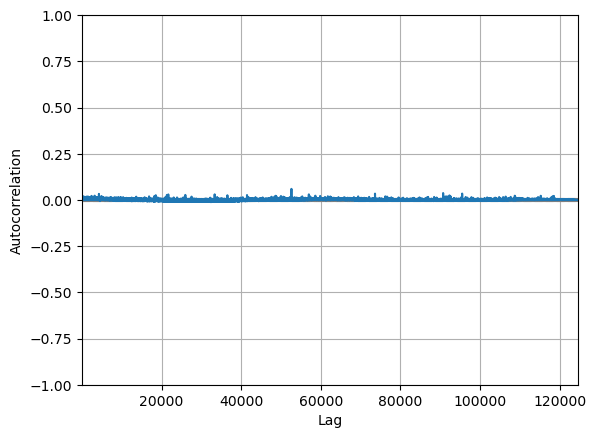

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Amount'])  # Replace 'value' with your column
plt.show()

In [ ]:
#univariate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Parameters
lookback = 1000

# We have df with columns ['ds', 'y']
# Sort by ds just to be sure
df = df.sort_values('Time').reset_index(drop=True)

values = df['Amount'].values.reshape(-1,1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(values)

all_indices = np.arange(len(df))
test_indices = np.concatenate([anomaly_indices, random_indices])
train_indices = np.setdiff1d(all_indices, test_indices)

# Create sequences from training data only
def create_sequences(data, indices, lookback=30):
    X, Y = [], []
    # We'll only form sequences where all lookback steps are in the training indices
    # One approach: filter data to training indices, then re-index them
    # Another approach: just iterate through possible starts
    # and ensure they + lookback fall within train_indices
    idx_set = set(indices)
    for i in range(len(data)-lookback):
        # Check if the sequence and target index are in training set
        window_indices = np.arange(i, i+lookback)
        target_index = i+lookback
        if set(window_indices).issubset(idx_set) and target_index in idx_set:
            X.append(data[window_indices])
            Y.append(data[target_index])
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(scaled_values, train_indices, lookback=lookback)
# print(X_train)
# print(len(X_train)) #104607
# print(len(Y_train)) #104607

# Build the LSTM model with 32 -> 32 -> 1
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, 1), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005))

# Train the model
model.fit(X_train, Y_train, epochs=1, batch_size=16, verbose=1)

# After training, let's predict on the entire dataset.
# We need to generate predictions for every index from `lookback` onward.
predictions = np.zeros(len(df))
predictions[:] = np.nan  # For the first lookback steps, we can't predict

# # Create sequences for entire dataset (one sequence at a time)
# for i in range(len(df)-lookback):
#     print('i', i)
#     seq = scaled_values[i:i+lookback]
#     seq = seq.reshape(1, lookback, 1)
#     pred = model.predict(seq, verbose=0)
#     predictions[i+lookback] = pred[0,0]

# Create sequences for entire dataset (Process in batches)
batch_size = 32
for i in range(0, len(df) - lookback, batch_size):
    print('i', i)
    # Generate the sequences for the current batch
    seq_batch = [scaled_values[i:i + lookback] for i in range(i, min(i + batch_size, len(df) - lookback))]
    # Reshape the batch to (batch_size, lookback, 1)
    seq_batch = np.array(seq_batch).reshape(-1, lookback, 1)
    # Make predictions for the entire batch at once
    preds = model.predict(seq_batch, verbose=0)
    # Assign predictions to the correct spots in the predictions array
    predictions[i + lookback:i + lookback + batch_size] = preds[:, 0]

# Inverse transform predictions
predictions_inv = scaler.inverse_transform(predictions.reshape(-1,1))

c:\Users\jennycc\Anaconda3\envs\TimeSeries\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 335ms/step - loss: 3.3662e-04
i 0
i 32
i 64
i 96
i 128
i 160
i 192
i 224
i 256
i 288
i 320
i 352
i 384
i 416
i 448
i 480
i 512
i 544
i 576
i 608
i 640
i 672
i 704
i 736
i 768
i 800
i 832
i 864
i 896
i 928
i 960
i 992
i 1024
i 1056
i 1088
i 1120
i 1152
i 1184
i 1216
i 1248
i 1280
i 1312
i 1344
i 1376
i 1408
i 1440
i 1472
i 1504
i 1536
i 1568
i 1600
i 1632
i 1664
i 1696
i 1728
i 1760
i 1792
i 1824
i 1856
i 1888
i 1920
i 1952
i 1984
i 2016
i 2048
i 2080
i 2112
i 2144
i 2176
i 2208
i 2240
i 2272
i 2304
i 2336
i 2368
i 2400
i 2432
i 2464
i 2496
i 2528
i 2560
i 2592
i 2624
i 2656
i 2688
i 2720
i 2752
i 2784
i 2816
i 2848
i 2880
i 2912
i 2944
i 2976
i 3008
i 3040
i 3072
i 3104
i 3136
i 3168
i 3200
i 3232
i 3264
i 3296
i 3328
i 3360
i 3392
i 3424
i 3456
i 3488
i 3520
i 3552
i 3584
i 3616
i 3648
i 3680
i 3712
i 3744
i 3776
i 3808
i 3840
i 3872
i 3904
i 3936
i 3968
i 4000
i 4032
i 4064
i 4096
i 4128
i 4160
i 4192
i 4224
i 4256
i 4288
i 4320
i 4352
i 4384
i 4416
i 4

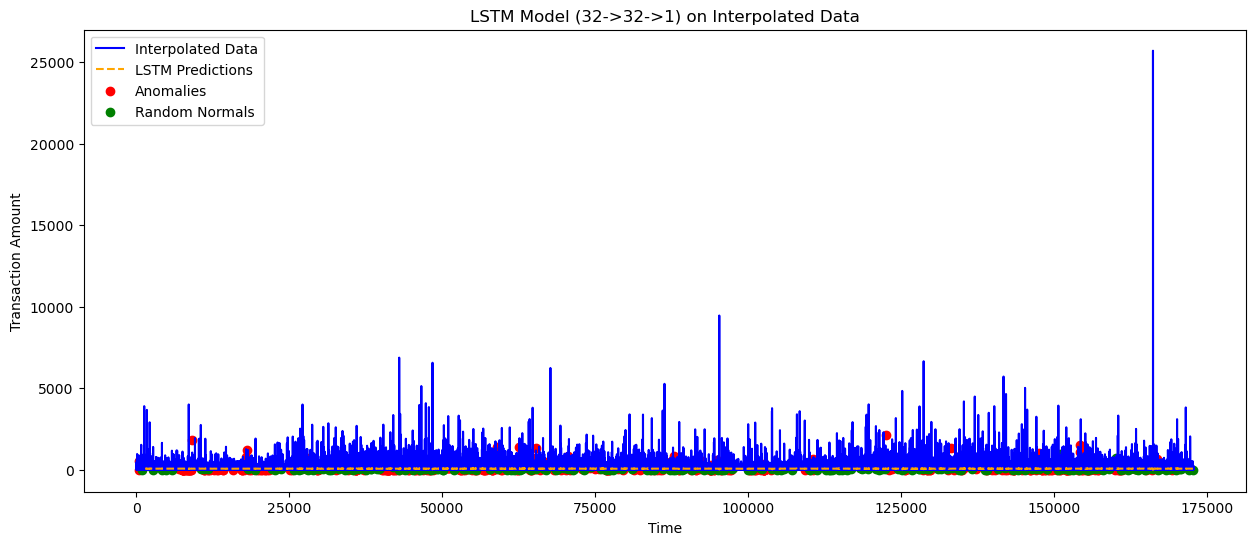

In [ ]:

# Plot results
fig, ax = plt.subplots(figsize=(15,6))

# Plot interpolated data (blue line)
ax.plot(df['Time'], df['Amount'], color='blue', label='Interpolated Data', linestyle='-',linewidth=1.5)

# Plot LSTM predictions (orange line)
ax.plot(df['Time'], predictions_inv, color='orange', label='LSTM Predictions', linestyle='--',linewidth=1.5)

# Mark anomalies (red dots)
ax.scatter(df.iloc[anomaly_indices]['Time'], df_original.iloc[anomaly_indices]['Amount'], color='red', label='Anomalies')

# Mark random normals (green dots)
ax.scatter(df.iloc[random_indices]['Time'], df_original.iloc[random_indices]['Amount'], color='green', label='Random Normals')

ax.set_title("LSTM Model (32->32->1) on Interpolated Data")
ax.set_xlabel('Time')
ax.set_ylabel('Transaction Amount')
ax.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Suppose we have:
# df['y'] for actual values (interpolated),
# predictions_inv for LSTM predictions (shape: (len(df), 1))
# anomaly_indices for anomalous points,
# random_indices for random normal points.

# Compute absolute residuals for all data points
abs_resid = np.abs(df['Amount'].values - predictions_inv.flatten())

# Extract residuals for anomalies and random normals
residuals_outliers = abs_resid[anomaly_indices]
residuals_random = abs_resid[random_indices]

alpha = 0.05  # For a 95% quantile
threshold = np.quantile(residuals_random, 1 - alpha)
print(f"Selected threshold at the 95% quantile of normal residuals: {threshold}")

# True labels: outliers = 1, normals = 0
true_labels = np.array([1]*len(residuals_outliers) + [0]*len(residuals_random))

# Combine residual arrays
all_residuals = np.concatenate([residuals_outliers, residuals_random])

# Predict anomaly if residual > threshold
predictions = (all_residuals > threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# Compute precision, recall, F1 score
precision = tp / (tp + fp) if (tp+fp) > 0 else 0
recall = tp / (tp + fn) if (tp+fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision+recall) > 0 else 0
predictions
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Selected threshold at the 95% quantile of normal residuals: nan
Confusion Matrix:
[[300   0]
 [468   0]]
TN: 300, FP: 0, FN: 468, TP: 0
Precision: 0.000, Recall: 0.000, F1: 0.000


In [ ]:
#multivariate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Parameters
lookback = 1000

# We have df with columns ['ds', 'y']
# Sort by ds just to be sure
df = df.sort_values('Time').reset_index(drop=True)
#print(df.shape) # 124592,31
# Select the features you want to use.
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
            'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
              'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 
              'V24', 'V25', 'V26', 'V27', 'V28']  # Add relevant features here
values = df[features].values
#print(values.shape) #124592,29

In [ ]:
#values = df['Amount'].values.reshape(-1,1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(values)
#print(len(scaled_values)) #124592
all_indices = np.arange(len(df))
test_indices = np.concatenate([anomaly_indices, random_indices])
train_indices = np.setdiff1d(all_indices, test_indices)
#print(len(train_indices)) #123824

124592


In [37]:

# Create sequences from training data only
def create_sequences(data, indices, lookback=30):
    X, Y = [], []
    # We'll only form sequences where all lookback steps are in the training indices
    # One approach: filter data to training indices, then re-index them
    # Another approach: just iterate through possible starts
    # and ensure they + lookback fall within train_indices
    idx_set = set(indices)
    for i in range(len(data)-lookback):
        # Check if the sequence and target index are in training set
        window_indices = np.arange(i, i+lookback)
        target_index = i+lookback
        if set(window_indices).issubset(idx_set) and target_index in idx_set:
            X.append(data[window_indices])
            Y.append(data[target_index, 0])
    return np.array(X), np.array(Y)

X_train, Y_train = create_sequences(scaled_values, train_indices, lookback=lookback)


[[[9.49743024e-04 9.22645562e-01 6.48852013e-01 ... 2.89224853e-01
   2.11170636e-01 5.73369558e-01]
  [1.87574247e-03 9.59665906e-01 6.45478728e-01 ... 3.74304976e-01
   2.14177072e-01 5.79440835e-01]
  [6.94402277e-04 8.80746836e-01 6.86167960e-01 ... 2.98554084e-01
   1.89318310e-01 5.80554350e-01]
  ...
  [3.88849706e-04 9.18749434e-01 6.52936907e-01 ... 1.67045079e-01
   2.16050530e-01 5.83657434e-01]
  [7.37607800e-04 9.73647525e-01 6.36583025e-01 ... 4.61572372e-01
   2.14839967e-01 5.78127425e-01]
  [1.65874176e-03 9.45469418e-01 6.54038656e-01 ... 3.03366616e-01
   2.09987152e-01 5.71125268e-01]]

 [[1.87574247e-03 9.59665906e-01 6.45478728e-01 ... 3.74304976e-01
   2.14177072e-01 5.79440835e-01]
  [6.94402277e-04 8.80746836e-01 6.86167960e-01 ... 2.98554084e-01
   1.89318310e-01 5.80554350e-01]
  [3.53727378e-03 9.21697504e-01 6.57282159e-01 ... 4.50564978e-01
   2.11462891e-01 5.77488572e-01]
  ...
  [7.37607800e-04 9.73647525e-01 6.36583025e-01 ... 4.61572372e-01
   2.14839

In [38]:

#print(X_train)
#print(Y_train)
print(X_train.shape) 
print(Y_train.shape)

(1226, 1000, 29)
(1226,)


In [45]:
# Build the LSTM model with 32 -> 32 -> 1
model = Sequential()
model.add(LSTM(32, input_shape=(lookback, X_train.shape[2]), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.005))

# Train the model
model.fit(X_train, Y_train, epochs=1, batch_size=16, verbose=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - loss: 3.6707e-04


In [ ]:
# After training, let's predict on the entire dataset.
# We need to generate predictions for every index from `lookback` onward.
predictions = np.zeros(len(df))
predictions[:] = np.nan  # For the first lookback steps, we can't predict

# # Create sequences for entire dataset
# for i in range(len(df)-lookback):
#     print('i', i)
#     seq = scaled_values[i:i+lookback]
#     seq = seq.reshape(1, lookback, X_train.shape[2])
#     pred = model.predict(seq, verbose=0)
#     predictions[i+lookback] = pred[0,0]

# Create sequences for entire dataset
batch_size = 32
for i in range(0, len(df) - lookback, batch_size):
    print('i', i)
    seq_batch = [scaled_values[i:i + lookback] for i in range(i, min(i + batch_size, len(df) - lookback))]
    seq_batch = np.array(seq_batch).reshape(-1, lookback, X_train.shape[2])
    preds = model.predict(seq_batch, verbose=0)
    predictions[i+lookback:i+lookback+batch_size] = preds[:,0]

# Inverse transform predictions
#predictions_inv = scaler.inverse_transform(predictions.reshape(-1,1))
predictions_inv = scaler.inverse_transform(np.column_stack((predictions, np.zeros((len(predictions), X_train.shape[2]-1)))))
predictions_inv = predictions_inv[:, 0]  # Only extract 'Amount'


i 0
i 32
i 64
i 96
i 128
i 160
i 192
i 224
i 256
i 288
i 320
i 352
i 384
i 416
i 448
i 480
i 512
i 544
i 576
i 608
i 640
i 672
i 704
i 736
i 768
i 800
i 832
i 864
i 896
i 928
i 960
i 992
i 1024
i 1056
i 1088
i 1120
i 1152
i 1184
i 1216
i 1248
i 1280
i 1312
i 1344
i 1376
i 1408
i 1440
i 1472
i 1504
i 1536
i 1568
i 1600
i 1632
i 1664
i 1696
i 1728
i 1760
i 1792
i 1824
i 1856
i 1888
i 1920
i 1952
i 1984
i 2016
i 2048
i 2080
i 2112
i 2144
i 2176
i 2208
i 2240
i 2272
i 2304
i 2336
i 2368
i 2400
i 2432
i 2464
i 2496
i 2528
i 2560
i 2592
i 2624
i 2656
i 2688
i 2720
i 2752
i 2784
i 2816
i 2848
i 2880
i 2912
i 2944
i 2976
i 3008
i 3040
i 3072
i 3104
i 3136
i 3168
i 3200
i 3232
i 3264
i 3296
i 3328
i 3360
i 3392
i 3424
i 3456
i 3488
i 3520
i 3552
i 3584
i 3616
i 3648
i 3680
i 3712
i 3744
i 3776
i 3808
i 3840
i 3872
i 3904
i 3936
i 3968
i 4000
i 4032
i 4064
i 4096
i 4128
i 4160
i 4192
i 4224
i 4256
i 4288
i 4320
i 4352
i 4384
i 4416
i 4448
i 4480
i 4512
i 4544
i 4576
i 4608
i 4640
i 4672
i 4704
i

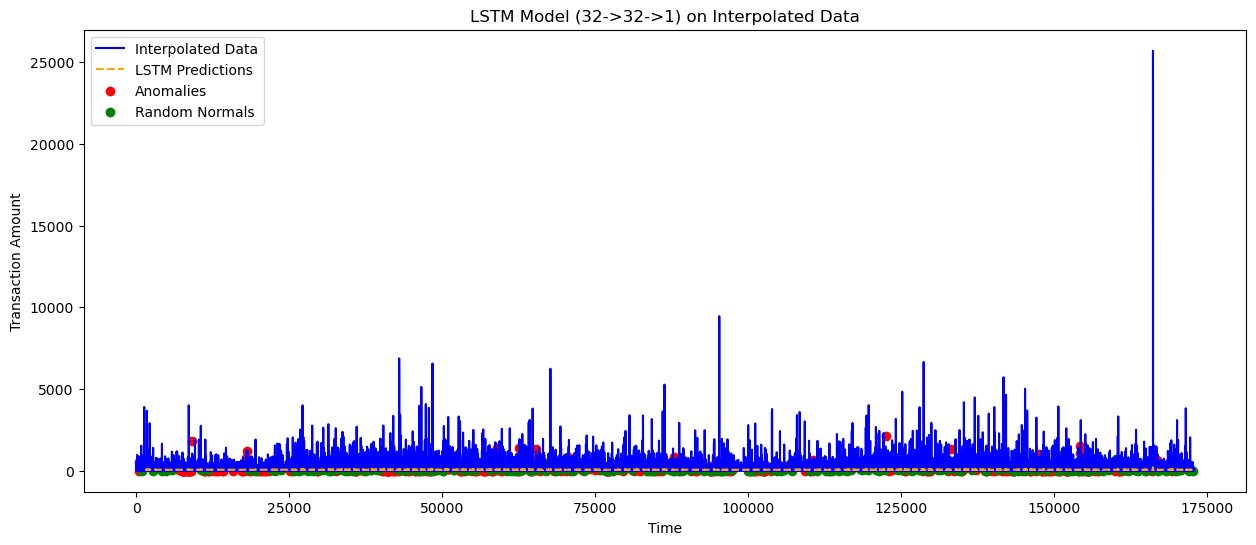

In [ ]:

# Plot results
fig, ax = plt.subplots(figsize=(15,6))

# Plot interpolated data (blue line)
ax.plot(df['Time'], df['Amount'], color='blue', label='Interpolated Data', linestyle='-',linewidth=1.5)

# Plot LSTM predictions (orange line)
ax.plot(df['Time'], predictions_inv, color='orange', label='LSTM Predictions', linestyle='--',linewidth=1.5)

# Mark anomalies (red dots)
ax.scatter(df.iloc[anomaly_indices]['Time'], df_original.iloc[anomaly_indices]['Amount'], color='red', label='Anomalies')

# Mark random normals (green dots)
ax.scatter(df.iloc[random_indices]['Time'], df_original.iloc[random_indices]['Amount'], color='green', label='Random Normals')

ax.set_title("LSTM Model (32->32->1) on Interpolated Data")
ax.set_xlabel('Time')
ax.set_ylabel('Transaction Amount')
ax.legend()
plt.show()
